In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.interpolate import BSpline, splev, splrep

from quantum_statistics.spacial_basis import BSplineSpacialBasisSet
from quantum_statistics import (
    ParticleProps, 
    harmonic_trap,
    box_trap,
    box_2d_harmonic_1d_trap,
    ring_beam_trap,
)

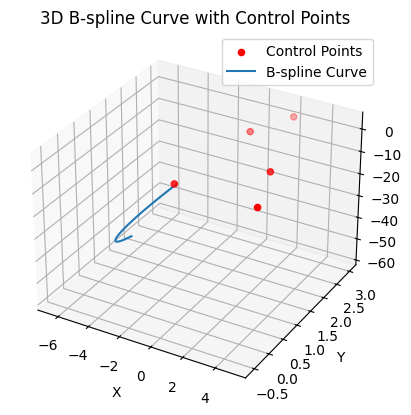

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

# Define 3D control points
control_points = np.array([
    [0, 0, 0],  # Control Point 1
    [1, 2, 3],  # Control Point 2
    [2, 3, 1],  # Control Point 3
    [4, 1, 2],  # Control Point 4
    [5, 0, 0]   # Control Point 5
])

# Define the degree of the B-spline (e.g., cubic B-spline)
degree = 3

# Generate a knot vector. You can customize this based on your requirements.
# Here, we use a simple uniform knot vector.
knot_vector = np.arange(len(control_points) + degree + 1)

# Create a B-spline object
bspline = BSpline(knot_vector, control_points, degree)

# Evaluate the B-spline at various parameter values to get points on the curve
num_points = 100  # Number of points to evaluate along the curve
u_values = np.linspace(0, len(control_points) - degree, num_points)  # Parameter values
curve_points = bspline(u_values)

# Plot the 3D B-spline curve
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot control points
ax.scatter(control_points[:, 0], control_points[:, 1], control_points[:, 2], c='red', label='Control Points')

# Plot B-spline curve
ax.plot(curve_points[:, 0], curve_points[:, 1], curve_points[:, 2], label='B-spline Curve')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D B-spline Curve with Control Points')
plt.legend()
plt.show()


In [2]:
def precompute_bspline_products(splines1, splines2):
    assert len(splines1) == len(splines2), "The spline lists must have the same length."

    bspline_products = {}

    for i, spline1 in enumerate(splines1):
        degree1 = spline1.k
        for j, spline2 in enumerate(splines2):
            degree2 = spline2.k

            # Calculate the actual non-zero intervals for each spline
            start1, end1 = spline1.t[i], spline1.t[i + degree1 + 1]
            start2, end2 = spline2.t[j], spline2.t[j + degree2 + 1]

            # Determine the overlap interval
            t_min = max(start1, start2)
            t_max = min(end1, end2)

            if t_max > t_min:  # If there is an actual overlap
                x = np.linspace(t_min, t_max, 1000)
                y1 = splev(x, spline1)
                y2 = splev(x, spline2)
                product = y1 * y2

                # Find B-spline representation of the product
                tck_product = splrep(x, product, s=0)
                bspline_product = BSpline(*tck_product)

                bspline_products[(i, j)] = (bspline_product, (t_min, t_max))

    return bspline_products

In [4]:
def precompute_3d_bspline_products(splines_x, splines_y, splines_z, degree_x, degree_y, degree_z):
    # Precompute the 1D B-spline products for each direction
    bspline_products_x = precompute_bspline_products(splines_x, degree_x)
    bspline_products_y = precompute_bspline_products(splines_y, degree_y)
    bspline_products_z = precompute_bspline_products(splines_z, degree_z)

    # Initialize the dictionary for 3D B-spline products
    bspline_products_3d = {}

    # Iterate over all combinations of non-zero 1D B-spline products
    for (ix, jx), bspline_x in bspline_products_x.items():
        for (iy, jy), bspline_y in bspline_products_y.items():
            for (iz, jz), bspline_z in bspline_products_z.items():
                # Create a key for the 3D product
                key_3d = ((ix, jx), (iy, jy), (iz, jz))

                # Define the 3D B-spline product as a lambda function
                bspline_product_3d = lambda x, y, z: splev(x, bspline_x) * splev(y, bspline_y) * splev(z, bspline_z)

                # Store the 3D B-spline product
                bspline_products_3d[key_3d] = bspline_product_3d

    return bspline_products_3d

In [5]:
basis_set = BSplineSpacialBasisSet(
    domain=[(-100,100), (-100,100), (-100,100)],
    degree=(3, 4, 5),
    num_knots=(51, 41, 31),
    #potential_function=harmonic_trap,
)

splines_x, splines_y, splines_z = basis_set._generate_splines()
d2splines_x = [spline.derivative(2) for spline in splines_x]
splines_x.shape

(47,)

In [6]:
spline = splines_x[0]
spline.t

array([-1.00000000e+02, -1.00000000e+02, -1.00000000e+02, -1.00000000e+02,
       -9.54545455e+01, -9.09090909e+01, -8.63636364e+01, -8.18181818e+01,
       -7.72727273e+01, -7.27272727e+01, -6.81818182e+01, -6.36363636e+01,
       -5.90909091e+01, -5.45454545e+01, -5.00000000e+01, -4.54545455e+01,
       -4.09090909e+01, -3.63636364e+01, -3.18181818e+01, -2.72727273e+01,
       -2.27272727e+01, -1.81818182e+01, -1.36363636e+01, -9.09090909e+00,
       -4.54545455e+00,  1.42108547e-14,  4.54545455e+00,  9.09090909e+00,
        1.36363636e+01,  1.81818182e+01,  2.27272727e+01,  2.72727273e+01,
        3.18181818e+01,  3.63636364e+01,  4.09090909e+01,  4.54545455e+01,
        5.00000000e+01,  5.45454545e+01,  5.90909091e+01,  6.36363636e+01,
        6.81818182e+01,  7.27272727e+01,  7.72727273e+01,  8.18181818e+01,
        8.63636364e+01,  9.09090909e+01,  9.54545455e+01,  1.00000000e+02,
        1.00000000e+02,  1.00000000e+02,  1.00000000e+02])

In [7]:
d2spline = d2splines_x[0]
d2spline.t

array([-1.00000000e+02, -1.00000000e+02, -9.54545455e+01, -9.09090909e+01,
       -8.63636364e+01, -8.18181818e+01, -7.72727273e+01, -7.27272727e+01,
       -6.81818182e+01, -6.36363636e+01, -5.90909091e+01, -5.45454545e+01,
       -5.00000000e+01, -4.54545455e+01, -4.09090909e+01, -3.63636364e+01,
       -3.18181818e+01, -2.72727273e+01, -2.27272727e+01, -1.81818182e+01,
       -1.36363636e+01, -9.09090909e+00, -4.54545455e+00,  1.42108547e-14,
        4.54545455e+00,  9.09090909e+00,  1.36363636e+01,  1.81818182e+01,
        2.27272727e+01,  2.72727273e+01,  3.18181818e+01,  3.63636364e+01,
        4.09090909e+01,  4.54545455e+01,  5.00000000e+01,  5.45454545e+01,
        5.90909091e+01,  6.36363636e+01,  6.81818182e+01,  7.27272727e+01,
        7.72727273e+01,  8.18181818e+01,  8.63636364e+01,  9.09090909e+01,
        9.54545455e+01,  1.00000000e+02,  1.00000000e+02])

In [8]:
len(splines_x), len(d2splines_x)

(47, 47)

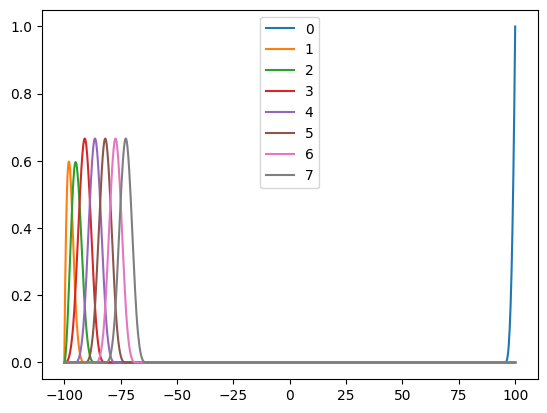

In [15]:
x = np.linspace(-100, 100, 1000)
plt.plot(x, splines_x[-1](x), label='0')
plt.plot(x, splines_x[1](x), label='1')
plt.plot(x, splines_x[2](x), label='2')
plt.plot(x, splines_x[3](x), label='3')
plt.plot(x, splines_x[4](x), label='4')
plt.plot(x, splines_x[5](x), label='5')
plt.plot(x, splines_x[6](x), label='6')
plt.plot(x, splines_x[7](x), label='7')
plt.legend()

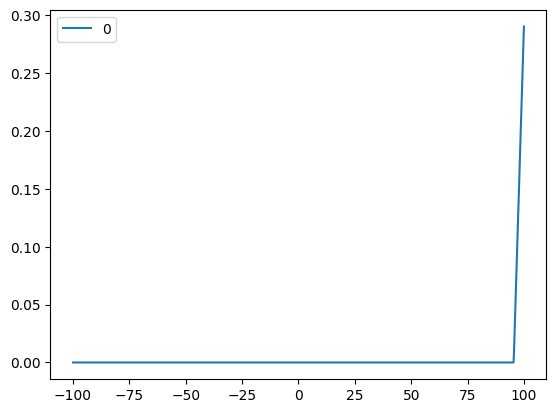

In [12]:
plt.plot(x, d2splines_x[-1](x), label='0')
#plt.plot(x, d2splines_x[1](x), label='1')
#plt.plot(x, d2splines_x[2](x), label='2')
#plt.plot(x, d2splines_x[3](x), label='3')
#plt.plot(x, d2splines_x[4](x), label='4')
#plt.plot(x, d2splines_x[5](x), label='5')
#plt.plot(x, d2splines_x[6](x), label='6')
#plt.plot(x, d2splines_x[7](x), label='7')
plt.legend()

In [11]:
products = precompute_bspline_products(splines_x, d2splines_x)
product = products[(16,18)]
product_spline = product[0]
a, b = product[1]
x = np.linspace(a, b, 1000)
plt.plot(x, product_spline(x))

IndexError: index 47 is out of bounds for axis 0 with size 47